In [63]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [64]:
sales_data = pd.read_csv('../../Data/SalesData.csv')
sales_data.head()

,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London
2,1-11-2015,11,4,2015,1,Injection 1,Dermafiller,Pharmacy 2,Outside London M25
3,1-11-2015,11,4,2015,1,Injection 2,Dermafiller,Pharmacy 2,Outside London M25
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands"


In [65]:
columns_to_drop= ['Pharmacy', 'Product', 'Location']
sales_data.drop(columns=columns_to_drop, inplace=True)

In [66]:
sales_data.head()

,Date,Month,Quarter,Year,Qty,Category
0,1-11-2015,11,4,2015,2,Skinbooster
1,1-11-2015,11,4,2015,1,Skinbooster
2,1-11-2015,11,4,2015,1,Dermafiller
3,1-11-2015,11,4,2015,1,Dermafiller
4,1-11-2015,11,4,2015,4,Skinbooster


In [67]:
encoder = OneHotEncoder()
encoder.fit(sales_data[['Category']])

OneHotEncoder()

In [68]:
encoded_columns = encoder.transform(sales_data[['Category']]).toarray()

In [69]:
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['Category']))
df = pd.concat([sales_data, encoded_df], axis=1)
df.drop('Category', axis=1, inplace=True)

In [70]:
df

,Date,Month,Quarter,Year,Qty,Category_Dermafiller,Category_Mesotherapy,Category_Needles,Category_Profilho,Category_Skinbooster,Category_Skincare
0,1-11-2015,11,4,2015,2,0.0,0.0,0.0,0.0,1.0,0.0
1,1-11-2015,11,4,2015,1,0.0,0.0,0.0,0.0,1.0,0.0
2,1-11-2015,11,4,2015,1,1.0,0.0,0.0,0.0,0.0,0.0
3,1-11-2015,11,4,2015,1,1.0,0.0,0.0,0.0,0.0,0.0
4,1-11-2015,11,4,2015,4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
68631,1-3-2022,3,1,2022,2,0.0,0.0,0.0,0.0,0.0,1.0
68632,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0
68633,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0
68634,1-3-2022,3,1,2022,1,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
df = df.groupby(['Date'],as_index=False)['Qty'].agg("sum")
print(df)

        Date    Qty
0   1-1-2016     76
1   1-1-2017    328
2   1-1-2018   2328
3   1-1-2019   4948
4   1-1-2020   6204
..       ...    ...
72  1-9-2017   1234
73  1-9-2018   4642
74  1-9-2019   6613
75  1-9-2020  10034
76  1-9-2021  12261

[77 rows x 2 columns]


In [72]:
df = df.rename(columns={'fecha': 'Date'})
df['Date'] = pd.to_datetime(df.Date, format="%d-%m-%Y")
df = df.set_index('Date')
#df = df.rename(columns={'x': 'y'})
df = df.asfreq('MS')
df = df.sort_index()
df.head()

# df['Date'] = pd.to_datetime(df.Date, format="%d-%m-%Y")
# df = df.sort_values(by='Date')
# df = df.set_index(df.Date)
# df.drop('Date', axis = 1, inplace = True)
# print('Column datatypes= \n',df.dtypes)
# df

,Qty
Date,
2015-11-01,9
2015-12-01,35
2016-01-01,76
2016-02-01,59
2016-03-01,144


In [73]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [74]:
# # Verify that a temporary index is complete
# # ==============================================================================
# (df.index == pd.date_range(start=df.index.min(),
#                              end=df.index.max(),
#                              freq=df.index.freq)).all()

In [75]:
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)

Shape of the data=  (77, 1)
Column datatypes= 
 Qty    int64
dtype: object


Train dates : 2015-11-01 00:00:00 --- 2021-03-01 00:00:00  (n=65)
Test dates  : 2021-04-01 00:00:00 --- 2022-03-01 00:00:00  (n=12)


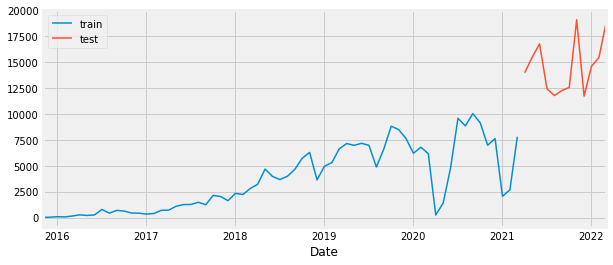

In [76]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Qty'].plot(ax=ax, label='train')
data_test['Qty'].plot(ax=ax, label='test')
ax.legend()

In [77]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['Qty'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-11-01 00:00:00'), Timestamp('2021-03-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-30 13:22:09 
Last fit date: 2023-03-30 13:22:09 
Skforecast version: 0.6.0 
Python version: 3.9.7 

In [78]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2021-04-01    5035.26
2021-05-01    6744.99
2021-06-01    6921.92
2021-07-01    5758.75
2021-08-01    5971.65
Freq: MS, Name: pred, dtype: float64

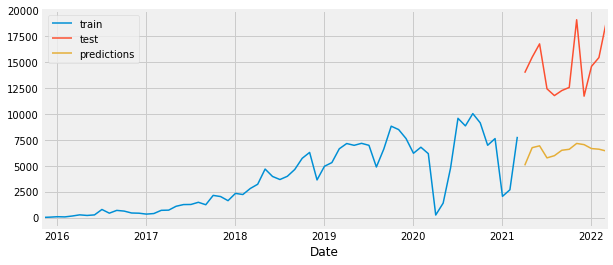

In [79]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Qty'].plot(ax=ax, label='train')
data_test['Qty'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [80]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Qty'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 71873212.11180834


In [82]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Qty'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:26<00:00, 13.14s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 7556177.203197576



In [83]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",7.556177e+06,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",7.567412e+06,5,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",7.619430e+06,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",7.664649e+06,5,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",7.692512e+06,3,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",8.054897e+06,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",8.628754e+06,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",8.666569e+06,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",8.823656e+06,10,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",8.905574e+06,3,100


In [84]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['Qty'])

In [85]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

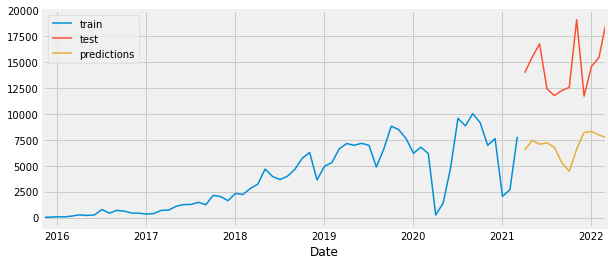

In [86]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Qty'].plot(ax=ax, label='train')
data_test['Qty'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [87]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Qty'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 64130911.29451546


In [98]:
# Backtesting
# ==============================================================================
steps = 12
n_backtesting = 12*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df['Qty'],
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 41
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   2015-11-01 00:00:00 -- 2019-03-01 00:00:00  (n=41)
    Validation: 2019-04-01 00:00:00 -- 2020-03-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   2015-11-01 00:00:00 -- 2020-03-01 00:00:00  (n=53)
    Validation: 2020-04-01 00:00:00 -- 2021-03-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   2015-11-01 00:00:00 -- 2021-03-01 00:00:00  (n=65)
    Validation: 2021-04-01 00:00:00 -- 2022-03-01 00:00:00  (n=12)

Backtest error: 27170794.29577355


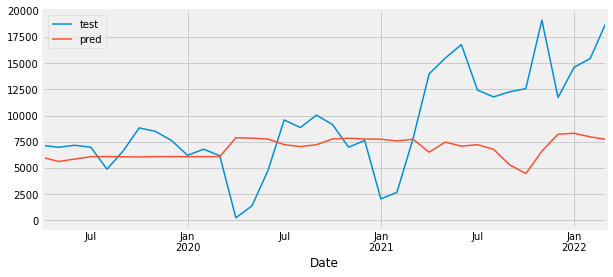

In [99]:
fig, ax = plt.subplots(figsize=(9, 4))
df.loc[predictions_backtest.index, 'Qty'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()

In [100]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.268599
1,lag_2,0.005640
2,lag_3,0.013102
3,lag_4,0.008432
4,lag_5,0.006820
5,lag_6,0.049984
6,lag_7,0.018639
7,lag_8,0.145432
8,lag_9,0.301391
9,lag_10,0.026083
